In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [2]:
print(plt.rcParamsDefault['figure.figsize'])

plt.rcParams = plt.rcParamsDefault

[8.0, 6.0]


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [4]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [11]:
#something is up with the other traning sample from before not fitting the data, 
#so I'm going to try this again

#load data:
f_halo = h5py.File('../m12i_res_7100_cdm/halo/halo_600.hdf5')

pos_halo = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo = f_halo['velocity'][:]

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos = pos_halo[host_id]
host_vel = vel_halo[host_id]

f = h5py.File('../m12i_res_7100_cdm/DM_data_w_stars_training.hdf5')

dm_mass = f['PartType1']['Masses'][:]
stellar_mass = f['PartType1']['Stellar_Masses'][:]
coords = f['PartType1']['Coordinates'][:]
vel = f['PartType1']['Velocities'][:]
mass_ratio = stellar_mass/dm_mass[0]

phase_space_coords =  np.concatenate((coords-host_pos,vel-host_vel),axis=1)

dist = np.linalg.norm(coords-host_pos,axis=1)
print(dist.shape)

non_zero_mask = (mass_ratio>0.0) #only want to train on things that are non-zero                                      

labels_non_zero = mass_ratio[non_zero_mask]
phase_space_non_zero = phase_space_coords[non_zero_mask]
dist_non_zero = dist[non_zero_mask]

f.close()

dm_mass, stellar_mass, coords, vel, mass_ratio = None,None,None,None,None

<ipython-input-11-d89f0539c826>:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_halo = h5py.File('../m12i_res_7100_cdm/halo/halo_600.hdf5')
<ipython-input-11-d89f0539c826>:19: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('../m12i_res_7100_cdm/DM_data_w_stars_training.hdf5')


(70514272,)


In [50]:
#Now I need to construct my model
#I'm going to take this from a stakeabuse post

#They claim you always want to normalize your data (what does that do and why)
#They use a sklearn function called StandardScaler

#So StandardScaler changes the data such that its mean is zero and its variance is one
#This is done for each "feature"

#why?

#First test_train split

X_train, X_test, y_train, y_test = train_test_split(phase_space_non_zero, labels_non_zero,
                                                   test_size=0.2, random_state=0)

sc = MinMaxScaler()
sc_y = MinMaxScaler()

#sc = StandardScaler()
#sc_y = StandardScaler()


sc.fit(X_train)
X_train = sc.transform(X_train)
sc.fit(X_test)
X_test = sc.transform(X_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

sc_y.fit(y_train)
y_train = sc_y.transform(y_train)
sc_y.fit(y_test)
y_test = sc_y.transform(y_test)

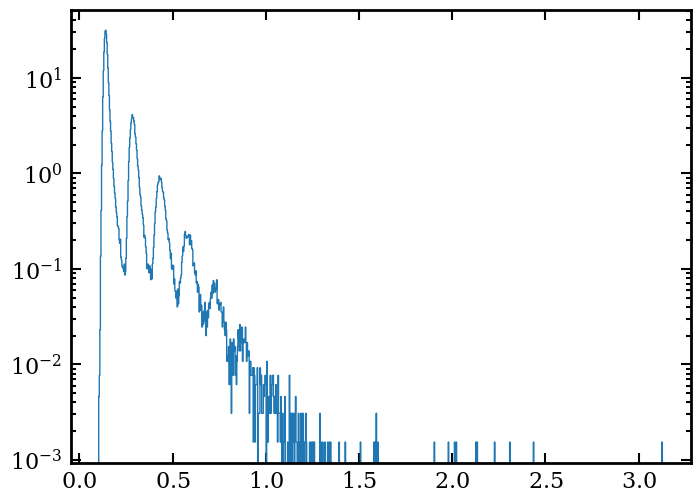

default
-1.1034299821004192e-16 1.0


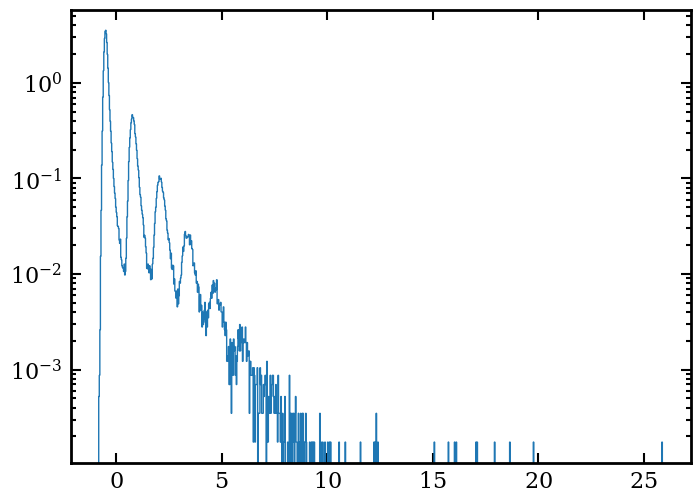

standard


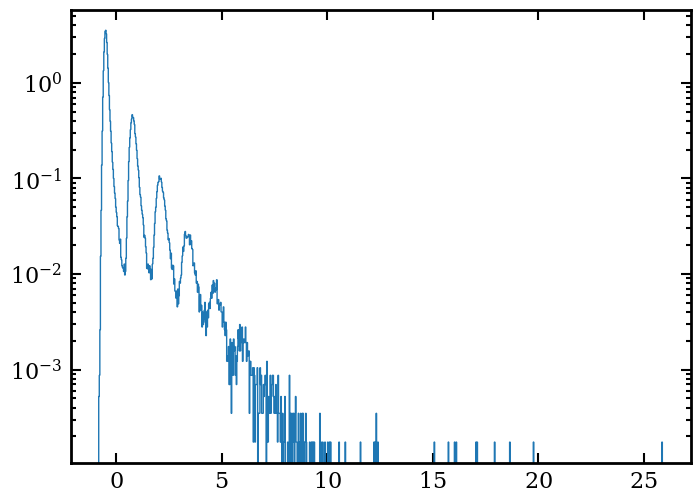

MinMax


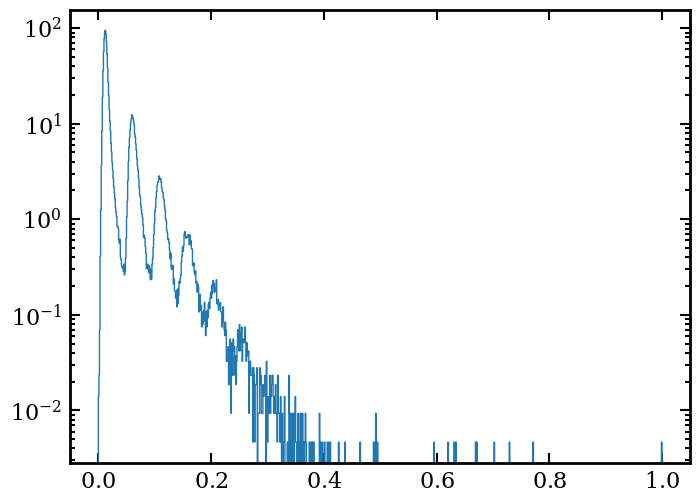

abs


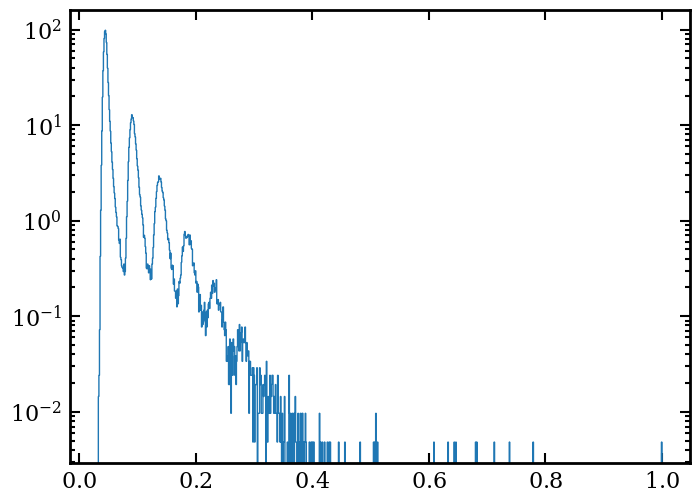

rob


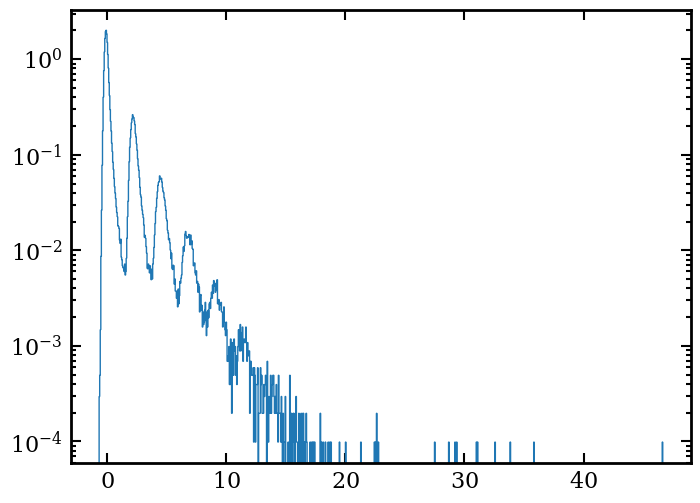

In [47]:
from sklearn import preprocessing
#Different types of scaling and how it impacts the distribution

#Frist save the defaults
X_train, X_test, y_train, y_test = train_test_split(phase_space_non_zero, labels_non_zero,
                                                   test_size=0.2, random_state=0)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#Here's what the default distro is
hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_test,bins=1000,histtype='step',color='C0',density=True)
#plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
#plt.xlim([-1.0,1.0])
plt.show()

#defualt scaling
#This changes the data so that the mean is zero and the variance is 1
y_scaled = preprocessing.scale(y_test)
print('default')
print(y_scaled.mean(),y_scaled.std())
hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_scaled,bins=1000,histtype='step',color='C0',density=True)
#plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
#plt.xlim([-1.0,1.0])
plt.show()

#Now scale it in various ways
sc_standard = StandardScaler().fit(y_test)
sc_MinMax = MinMaxScaler().fit(y_test)
#MinMax scales such that the minimum of the data is 0 and the max is 1
#MaxAbs scales such that the absolute value is between 0 and 1 (so -1 and 1?)
#These are meant for data already near zero (so potentially x and v but not m)

sc_abs = preprocessing.MaxAbsScaler().fit(y_test)
#sc = preprocessing.scale()
sc_rob = preprocessing.RobustScaler().fit(y_test)

y_standard = sc_standard.transform(y_test)
y_MinMax = sc_MinMax.transform(y_test)
y_abs = sc_abs.transform(y_test)
#y_sc = sc.transform(y_test)
y_rob = sc_rob.transform(y_test)

print('standard')
hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_standard,bins=1000,histtype='step',color='C0',density=True)
#plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
#plt.xlim([-1.0,1.0])
plt.show()

print('MinMax')
hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_MinMax,bins=1000,histtype='step',color='C0',density=True)
#plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
#plt.xlim([-1.0,1.0])
plt.show()

print('abs')
hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_abs,bins=1000,histtype='step',color='C0',density=True)
#plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
#plt.xlim([-1.0,1.0])
plt.show()

print('rob')
hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_rob,bins=1000,histtype='step',color='C0',density=True)
#plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
#plt.xlim([-1.0,1.0])
plt.show()



In [18]:
#Now I want to build my model. I still don't understand the specifics of model creation
#In that I don't know how to select the layers and nodes appropriately 

#In this tutorial it looks like they build their layers iteratively

from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model,Sequential

#input_layer = Input(shape=(phase_space_non_zero.shape[1],))
#dense_layer_1 = Dense(100, activation='relu')(input_layer)
#dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
#dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
#output = Dense(1)(dense_layer_3)

#input_layer = Input(shape=(phase_space_non_zero.shape[1],))
#dense_layer_1 = Dense(100, activation='relu')(input_layer)
#dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
#dense_layer_3 = Dense(25, activation='relu')(input_layer)
#output = Dense(1)(dense_layer_3)

#model = Model(inputs=input_layer,outputs=output)
#model.compile(loss="mean_squared_error",optimizer='adam',metrics=["mean_squared_error"])

#From some rando on the interenet he says more layers makes a worse fit, also he
#uses a different activation (tanh instead of linear or relu)


#model = Sequential()
#model.add(Dense(20, activation='tanh',input_dim=6,kernel_initializer='uniform'))
#model.add(Dense(10, activation='tanh',kernel_initializer='uniform'))
#model.add(Dense(1,activation='linear',kernel_initializer='uniform'))
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model = Sequential()
model.add(Dense(7, input_dim=6,kernel_initializer='normal', activation='relu'))
model.add(Dense(100000, activation='relu'))
model.add(Dense(1,activation='linear'))

# Model is derived and compiled using mean square error as loss
# function, accuracy as metric and gradient descent optimizer.
model.compile(loss='mse', optimizer='adam', metrics=["mse",'mae'])

Epoch 1/30
688/688 [==============================] - 286s 415ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0291 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0295
Epoch 2/30
688/688 [==============================] - 286s 416ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0298
Epoch 3/30
688/688 [==============================] - 294s 427ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0295
Epoch 4/30
688/688 [==============================] - 301s 437ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0303
Epoch 5/30
688/688 [==============================] - 290s 422ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0285
Epoch 6/30
688/688 [==============================] - 288s 418ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae:

AttributeError: 'list' object has no attribute 'lower'

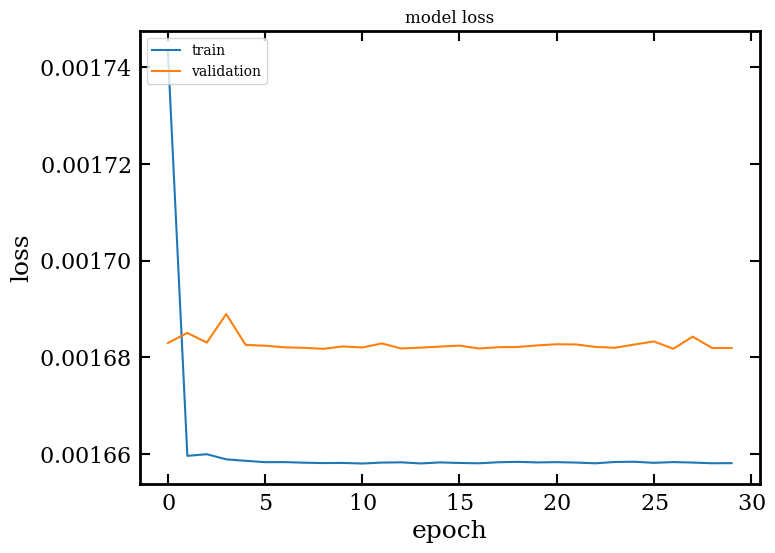

In [19]:
epochs = 30

history = model.fit(X_train,y_train,batch_size=1000,epochs=epochs,verbose=1
                    ,validation_split=0.2)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlim([0.0,0.002])
plt.show()

In [15]:
model_output = model.predict(X_test)

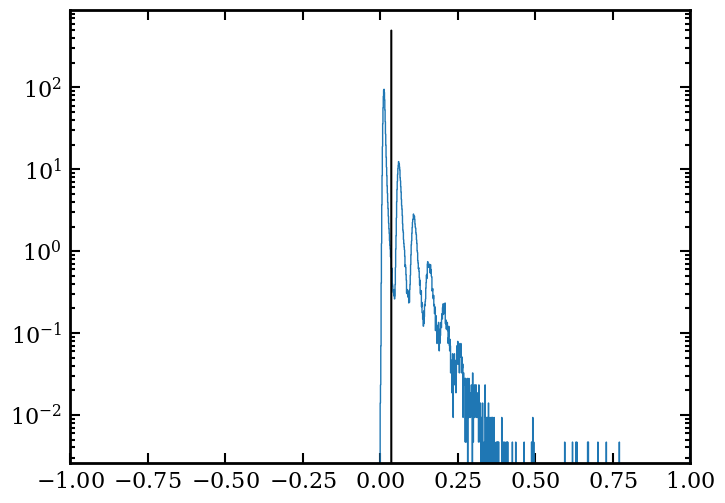

In [16]:
hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_test,bins=1000,histtype='step',color='C0',density=True)
plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
plt.xlim([-1.0,1.0])
plt.show()

In [ ]:
#gonna try gaussian process from sklearn, you can do a gaussian process in TF
#but it seems super hard to parse and unintuitive

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn import preprocessing
from sklearn import utils


bg_gp = BaggingRegressor(base_estimator=GaussianProcessRegressor(),n_estimators=100,n_jobs=4
                         ,max_samples=10000,bootstrap=True,verbose=True)

bg_gp.fit(X_train,y_train)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


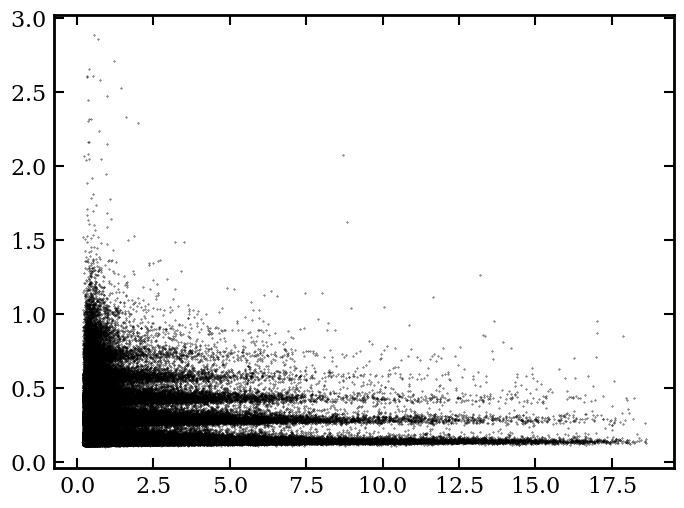

In [11]:
train_dist = np.sqrt(X_train[:,0]**2.0+X_train[:,1]**2.0+X_train[:,2]**2.0)

plt.scatter(train_dist,y_train,s=0.1,color='k')
plt.show()

In [8]:
X_train[::1000].shape


(860, 6)

In [16]:
pred_train = bg_gp.predict(X_train[::10])
pred_test = bg_gp.predict(X_test[::10])

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   21.8s remaining:   21.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   22.7s finished


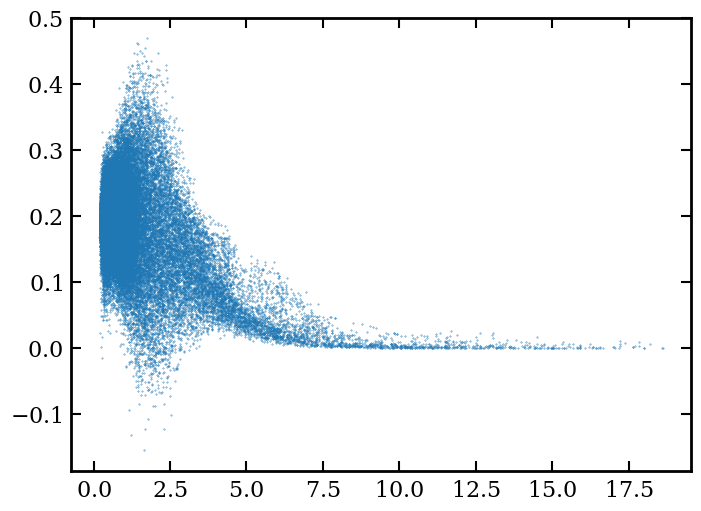

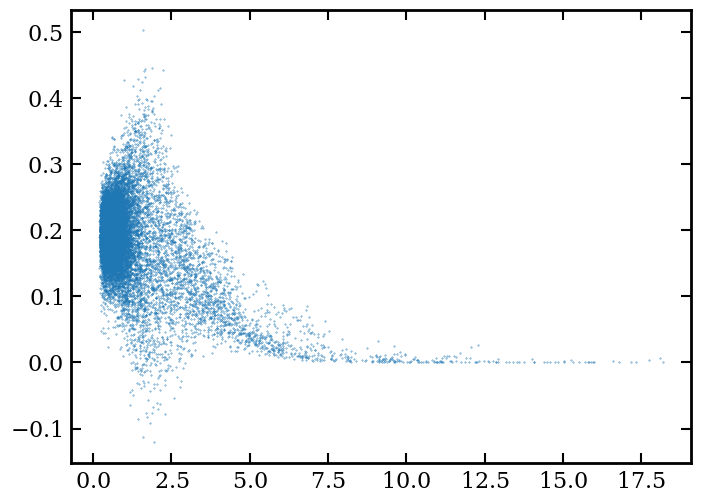

In [18]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

elu
Epoch 1/10
688/688 [==============================] - 34s 50ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0296 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0311
Epoch 2/10
688/688 [==============================] - 35s 50ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0288 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0273
Epoch 3/10
688/688 [==============================] - 34s 50ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0296
Epoch 4/10
688/688 [==============================] - 35s 50ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0287
Epoch 5/10
688/688 [==============================] - 35s 50ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0293
Epoch 6/10
688/688 [==============================] - 35s 51ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0289


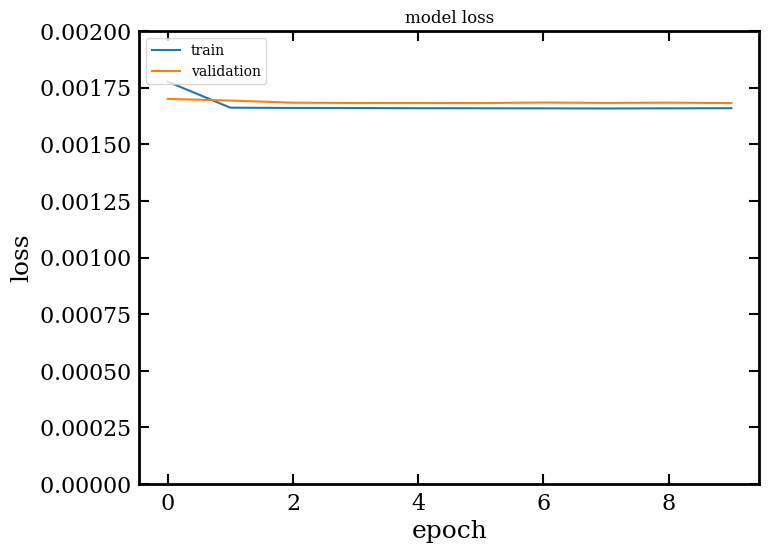

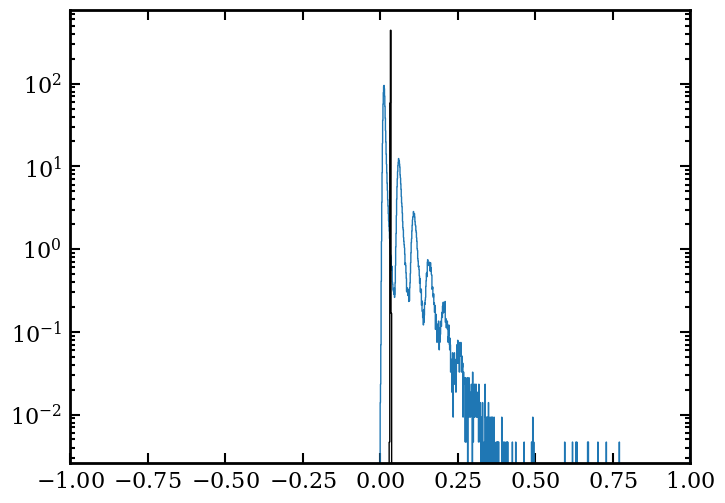

selu
Epoch 1/10
688/688 [==============================] - 31s 46ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0303 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0271
Epoch 2/10
688/688 [==============================] - 30s 44ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0288 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0291
Epoch 3/10
688/688 [==============================] - 30s 44ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0294
Epoch 4/10
688/688 [==============================] - 30s 44ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0300
Epoch 5/10
688/688 [==============================] - 29s 43ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0292
Epoch 6/10
688/688 [==============================] - 29s 42ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0287

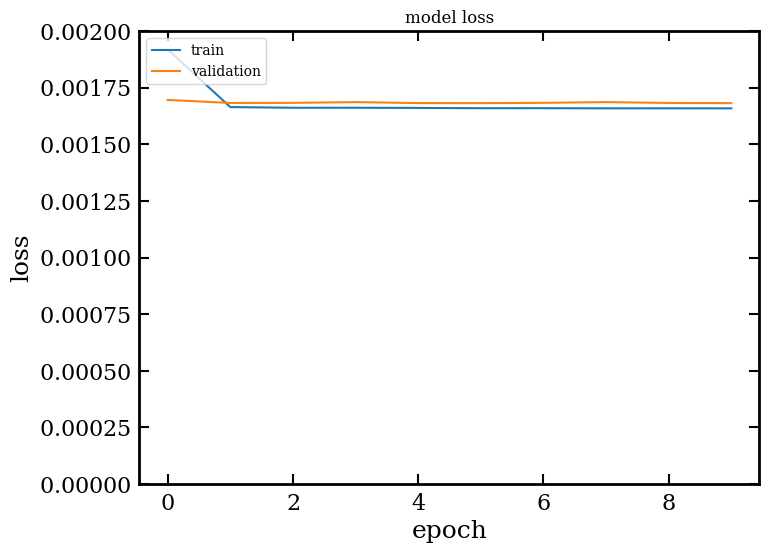

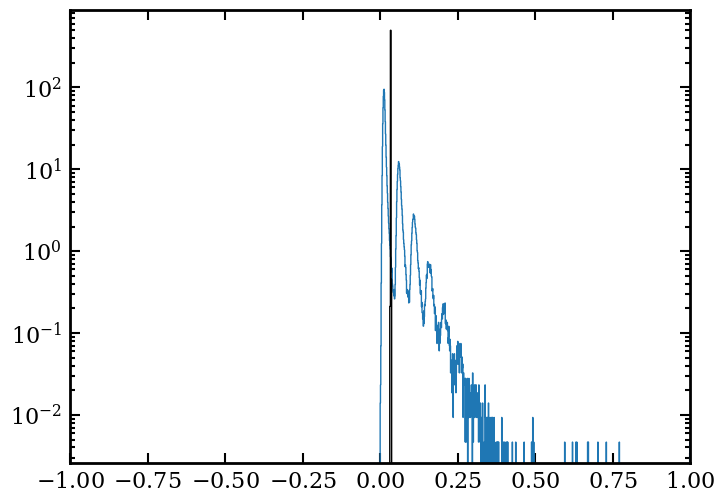

sigmoid
Epoch 1/10
688/688 [==============================] - 28s 41ms/step - loss: 0.1261 - mse: 0.1261 - mae: 0.0982 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0276
Epoch 2/10
688/688 [==============================] - 28s 41ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0289 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0235
Epoch 3/10
688/688 [==============================] - 28s 41ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0689 - val_loss: 0.0491 - val_mse: 0.0491 - val_mae: 0.2181
Epoch 4/10
688/688 [==============================] - 28s 41ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.1070 - val_loss: 0.0898 - val_mse: 0.0898 - val_mae: 0.2970
Epoch 5/10
688/688 [==============================] - 29s 42ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.0980 - val_loss: 0.2028 - val_mse: 0.2028 - val_mae: 0.4485
Epoch 6/10
688/688 [==============================] - 29s 43ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.0961 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0

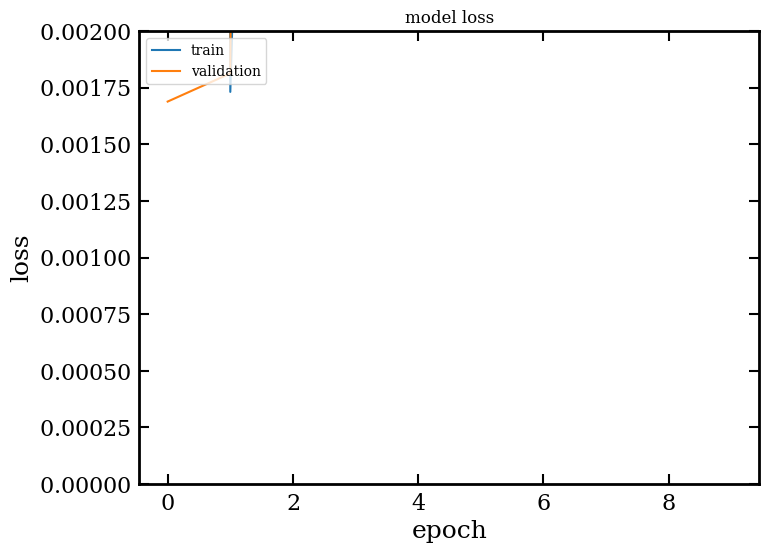

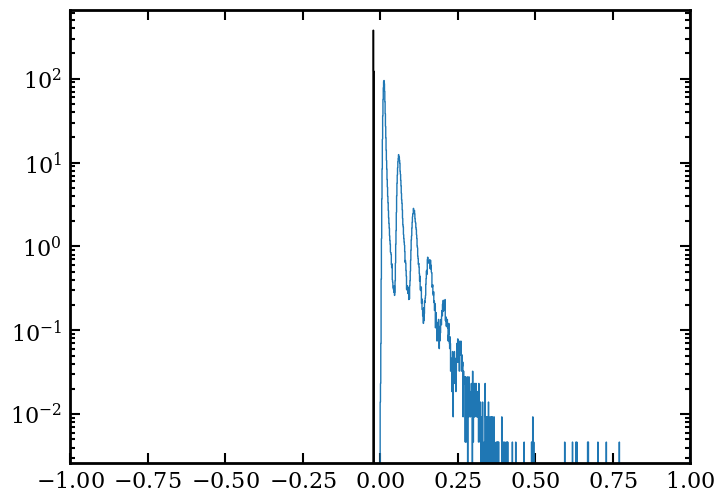

swish
Epoch 1/10
688/688 [==============================] - 71s 103ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0288 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0280
Epoch 2/10
688/688 [==============================] - 71s 103ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0295
Epoch 3/10
688/688 [==============================] - 70s 102ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0289
Epoch 4/10
688/688 [==============================] - 70s 102ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0300
Epoch 5/10
688/688 [==============================] - 71s 104ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0282
Epoch 6/10
688/688 [==============================] - 71s 104ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae:

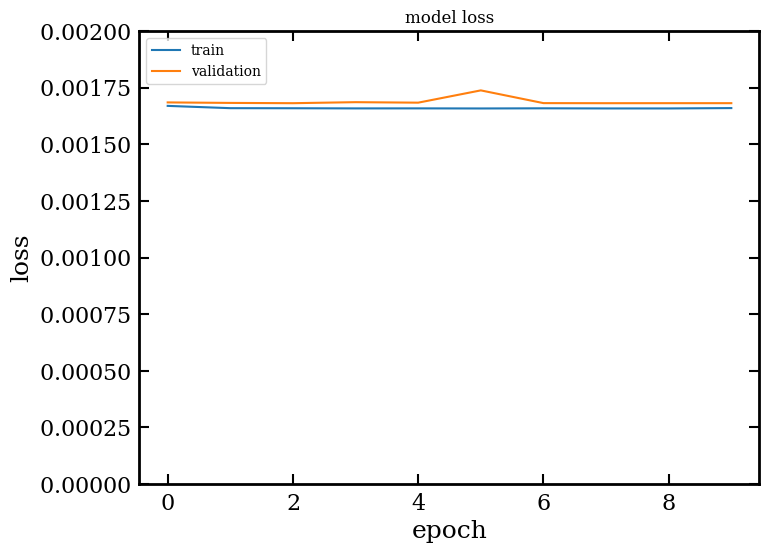

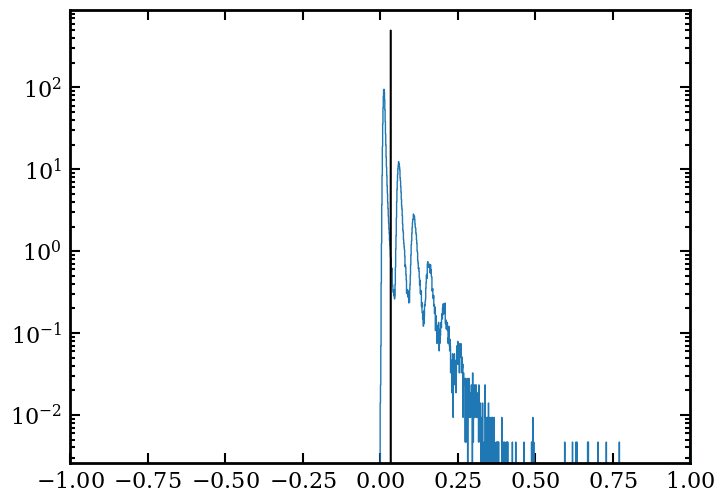

tanh
Epoch 1/10
688/688 [==============================] - 28s 41ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0294 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0282
Epoch 2/10
688/688 [==============================] - 28s 41ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0310
Epoch 3/10
688/688 [==============================] - 29s 42ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0301
Epoch 4/10
688/688 [==============================] - 29s 42ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0298
Epoch 5/10
688/688 [==============================] - 30s 43ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0294
Epoch 6/10
688/688 [==============================] - 29s 42ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0287

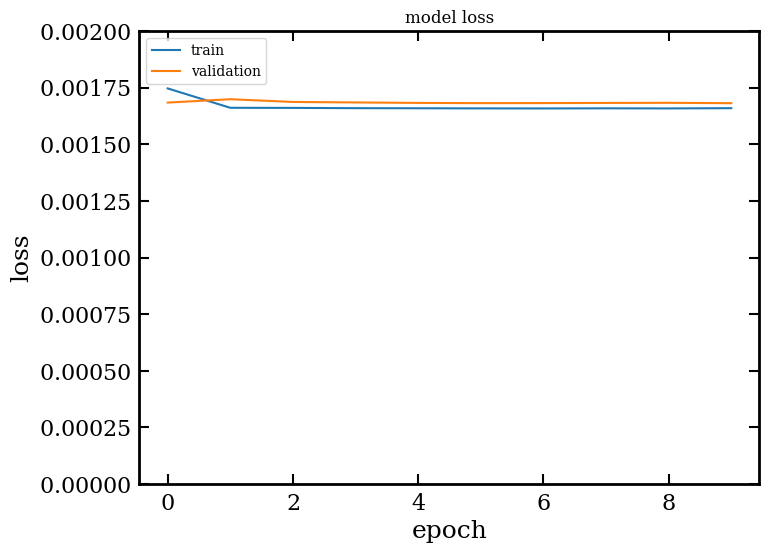

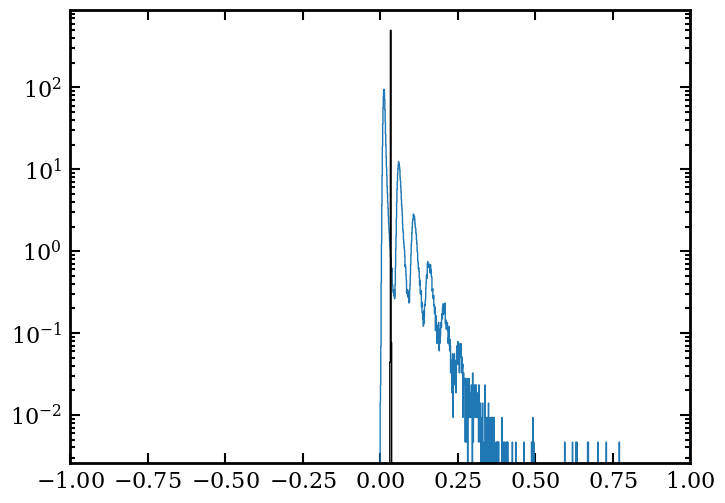

In [51]:
#Lets try various actviation tests
#elu,relu,selu,sigmoid,swish,tanh

activation_list = ['elu','selu','sigmoid','swish','tanh']

for activ in activation_list:
    print(activ)
    model = Sequential()
    model.add(Dense(7, input_dim=6,kernel_initializer='normal', activation=activ))
    model.add(Dense(10000, activation=activ))
    model.add(Dense(1,activation='linear'))

    # Model is derived and compiled using mean square error as loss
    # function, accuracy as metric and gradient descent optimizer.
    model.compile(loss='mse', optimizer='adam', metrics=["mse",'mae'])

    epochs = 10

    history = model.fit(X_train,y_train,batch_size=1000,epochs=epochs,verbose=1
                        ,validation_split=0.2)

    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim([0.0,0.002])
    plt.show()

    model_output = model.predict(X_test)

    hist_bins = np.linspace(-1.0,1.0,1000)
    plt.hist(y_test,bins=1000,histtype='step',color='C0',density=True)
    plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
    plt.yscale('log')
    plt.xlim([-1.0,1.0])
    plt.show()

Standard
Epoch 1/10
688/688 [==============================] - 34s 50ms/step - loss: 0.9975 - mse: 0.9975 - mae: 0.7051 - val_loss: 1.0121 - val_mse: 1.0121 - val_mae: 0.7076
Epoch 2/10
688/688 [==============================] - 33s 48ms/step - loss: 0.9973 - mse: 0.9973 - mae: 0.7050 - val_loss: 1.0118 - val_mse: 1.0118 - val_mae: 0.7153
Epoch 3/10
688/688 [==============================] - 32s 47ms/step - loss: 0.9973 - mse: 0.9973 - mae: 0.7048 - val_loss: 1.0117 - val_mse: 1.0117 - val_mae: 0.7119
Epoch 4/10
688/688 [==============================] - 32s 47ms/step - loss: 0.9972 - mse: 0.9972 - mae: 0.7050 - val_loss: 1.0116 - val_mse: 1.0116 - val_mae: 0.7100
Epoch 5/10
688/688 [==============================] - 32s 47ms/step - loss: 0.9973 - mse: 0.9973 - mae: 0.7051 - val_loss: 1.0116 - val_mse: 1.0116 - val_mae: 0.7096
Epoch 6/10
688/688 [==============================] - 32s 47ms/step - loss: 0.9973 - mse: 0.9973 - mae: 0.7054 - val_loss: 1.0119 - val_mse: 1.0119 - val_mae: 0.

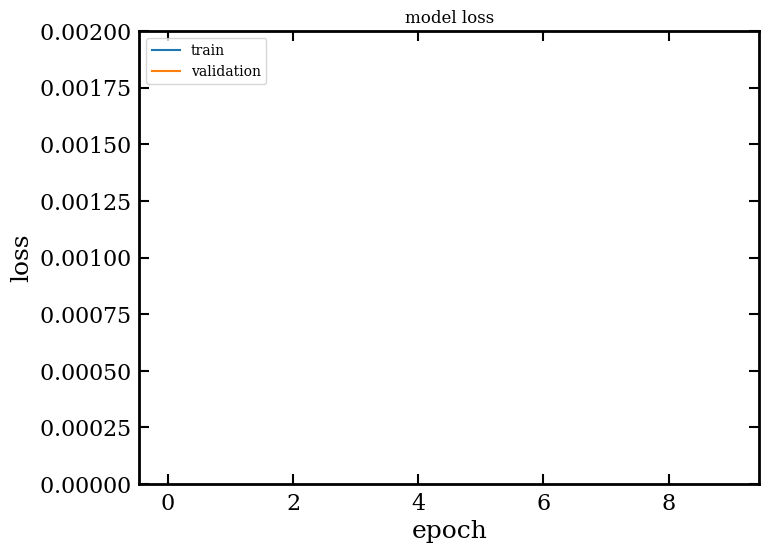

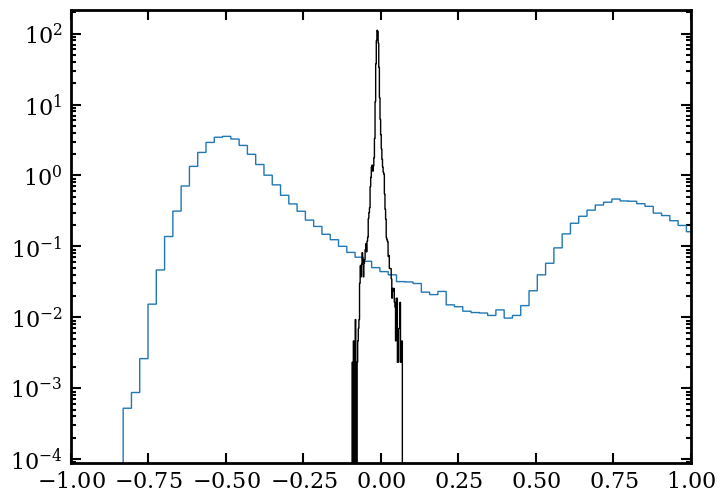

MinMax
Epoch 1/10
688/688 [==============================] - 33s 48ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0292 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0313
Epoch 2/10
688/688 [==============================] - 33s 48ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0290
Epoch 3/10
688/688 [==============================] - 32s 46ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0306
Epoch 4/10
688/688 [==============================] - 32s 46ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0281
Epoch 5/10
688/688 [==============================] - 32s 46ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0288
Epoch 6/10
688/688 [==============================] - 32s 46ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.02

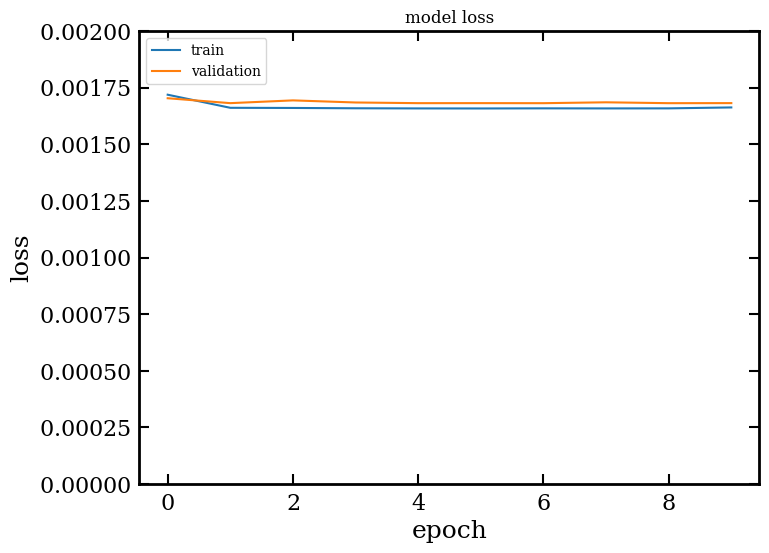

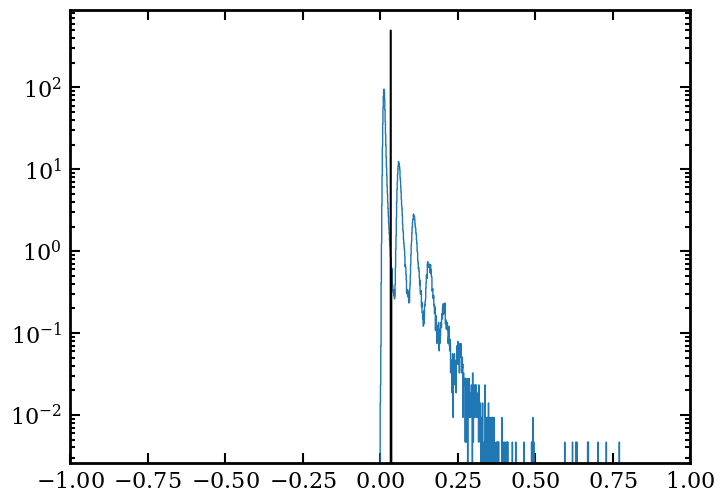

MaxAbs
Epoch 1/10
688/688 [==============================] - 33s 47ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0279 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0283
Epoch 2/10
688/688 [==============================] - 33s 48ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0275
Epoch 3/10
688/688 [==============================] - 32s 47ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0292
Epoch 4/10
688/688 [==============================] - 32s 47ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0290
Epoch 5/10
688/688 [==============================] - 32s 47ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0291
Epoch 6/10
688/688 [==============================] - 32s 47ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.02

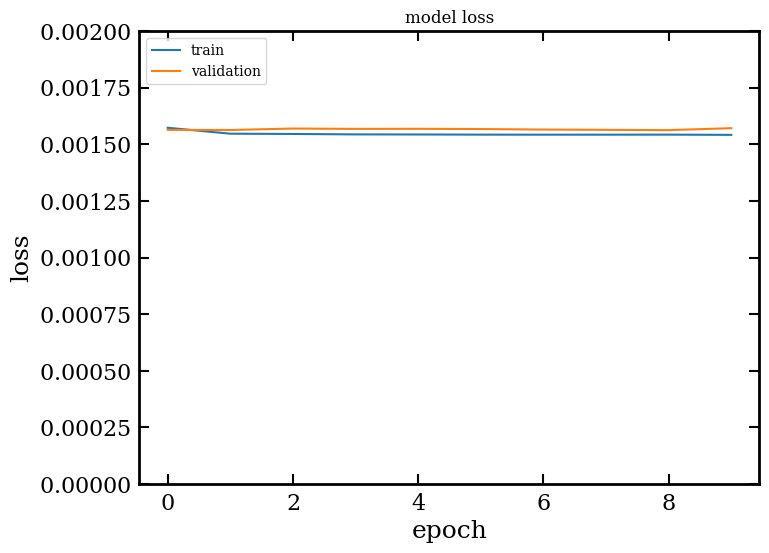

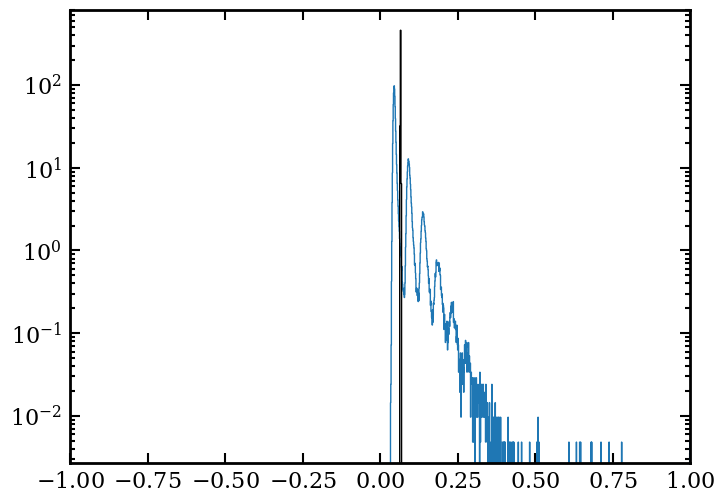

Robust
Epoch 1/10
688/688 [==============================] - 33s 47ms/step - loss: 3.7736 - mse: 3.7736 - mae: 1.3679 - val_loss: 3.8215 - val_mse: 3.8215 - val_mae: 1.3933
Epoch 2/10
688/688 [==============================] - 30s 44ms/step - loss: 3.7684 - mse: 3.7684 - mae: 1.3693 - val_loss: 3.8211 - val_mse: 3.8211 - val_mae: 1.3694
Epoch 3/10
688/688 [==============================] - 30s 44ms/step - loss: 3.7678 - mse: 3.7678 - mae: 1.3694 - val_loss: 3.8245 - val_mse: 3.8245 - val_mae: 1.3483
Epoch 4/10
688/688 [==============================] - 31s 45ms/step - loss: 3.7682 - mse: 3.7682 - mae: 1.3694 - val_loss: 3.8228 - val_mse: 3.8228 - val_mae: 1.3960
Epoch 5/10
688/688 [==============================] - 31s 46ms/step - loss: 3.7680 - mse: 3.7680 - mae: 1.3698 - val_loss: 3.8213 - val_mse: 3.8213 - val_mae: 1.3913
Epoch 6/10
688/688 [==============================] - 32s 46ms/step - loss: 3.7679 - mse: 3.7679 - mae: 1.3694 - val_loss: 3.8206 - val_mse: 3.8206 - val_mae: 1.37

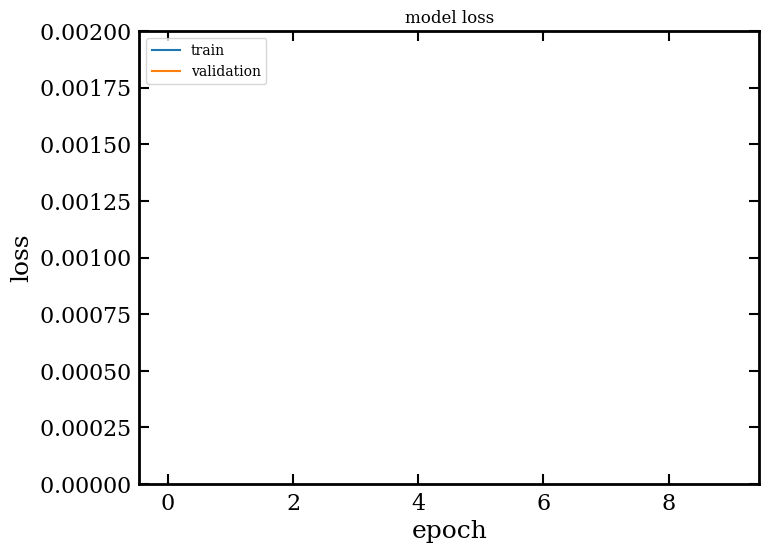

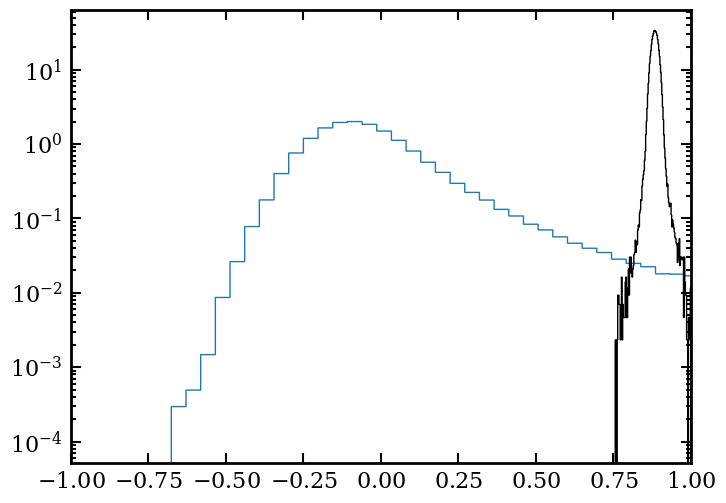

In [64]:
#Now here I'm going to try different scalings and then a hybrid scaling 

scaler_list = ['Standard','MinMax','MaxAbs','Robust']

for scaler in scaler_list:
    if scaler=='Standard':
        sc = StandardScaler()
    elif scaler=='MinMax':
        sc = MinMaxScaler()
    elif scaler=='MaxAbs':
        sc = preprocessing.MaxAbsScaler()
    elif scaler=='Robust':
        sc = preprocessing.RobustScaler()

    print(scaler)
    X_train, X_test, y_train, y_test = train_test_split(phase_space_non_zero, labels_non_zero,
                                                   test_size=0.2, random_state=0)
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    sc.fit(X_test)
    X_test = sc.transform(X_test)

    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)

    sc.fit(y_train)
    y_train = sc.transform(y_train)
    sc.fit(y_test)
    y_test = sc.transform(y_test)
    
    model = Sequential()
    model.add(Dense(7, input_dim=6,kernel_initializer='normal', activation=activ))
    model.add(Dense(10000, activation=activ))
    model.add(Dense(1,activation='linear'))

    # Model is derived and compiled using mean square error as loss
    # function, accuracy as metric and gradient descent optimizer.
    model.compile(loss='mse', optimizer='adam', metrics=["mse",'mae'])

    epochs = 10

    history = model.fit(X_train,y_train,batch_size=1000,epochs=epochs,verbose=1
                        ,validation_split=0.2)

    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim([0.0,0.002])
    plt.show()

    model_output = model.predict(X_test)

    hist_bins = np.linspace(-1.0,1.0,1000)
    plt.hist(y_test,bins=1000,histtype='step',color='C0',density=True)
    plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
    plt.yscale('log')
    plt.xlim([-1.0,1.0])
    plt.show()
    

Epoch 1/10
688/688 [==============================] - 36s 53ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0280 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0286
Epoch 2/10
688/688 [==============================] - 43s 62ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0290
Epoch 3/10
688/688 [==============================] - 41s 60ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0298
Epoch 4/10
688/688 [==============================] - 39s 57ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0267
Epoch 5/10
688/688 [==============================] - 38s 56ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0278
Epoch 6/10
688/688 [==============================] - 39s 57ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0276
Epoc

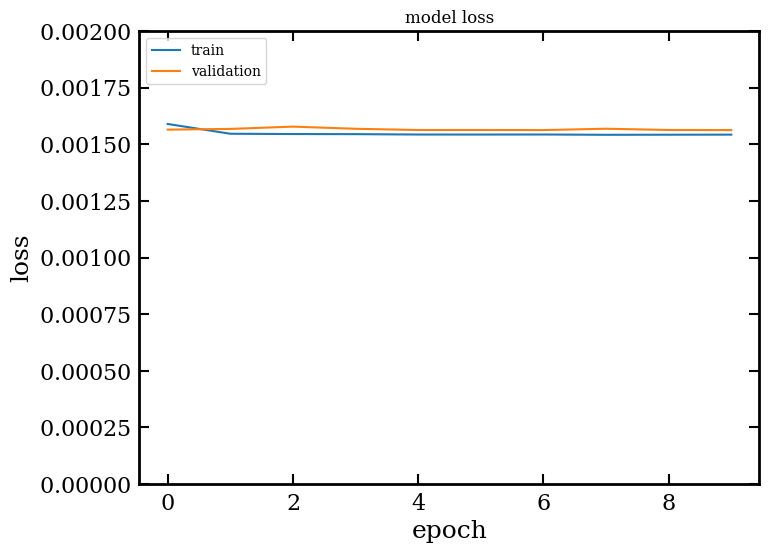

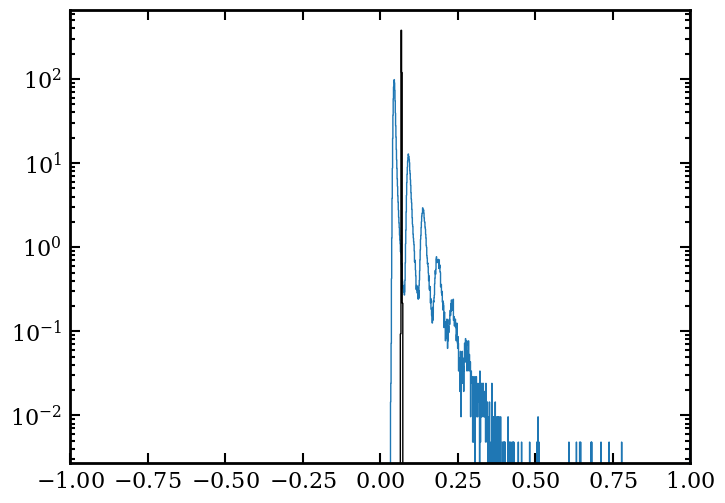

In [65]:
#Now lets try a mixture of max abs for the y and standard for X

X_train, X_test, y_train, y_test = train_test_split(phase_space_non_zero, labels_non_zero,
                                               test_size=0.2, random_state=0)

sc_y = preprocessing.MaxAbsScaler()
sc_x = StandardScaler()

sc_x.fit(X_train)
X_train = sc_x.transform(X_train)
sc_x.fit(X_test)
X_test = sc_x.transform(X_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

sc_y.fit(y_train)
y_train = sc_y.transform(y_train)
sc_y.fit(y_test)
y_test = sc_y.transform(y_test)

model = Sequential()
model.add(Dense(7, input_dim=6,kernel_initializer='normal', activation=activ))
model.add(Dense(10000, activation=activ))
model.add(Dense(1,activation='linear'))

# Model is derived and compiled using mean square error as loss
# function, accuracy as metric and gradient descent optimizer.
model.compile(loss='mse', optimizer='adam', metrics=["mse",'mae'])

epochs = 10

history = model.fit(X_train,y_train,batch_size=1000,epochs=epochs,verbose=1
                    ,validation_split=0.2)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0.0,0.002])
plt.show()

model_output = model.predict(X_test)

hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_test,bins=1000,histtype='step',color='C0',density=True)
plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
plt.xlim([-1.0,1.0])
plt.show()

Epoch 1/50
69/69 [==============================] - 33s 482ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0300 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0275
Epoch 2/50
69/69 [==============================] - 33s 476ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0275
Epoch 3/50
69/69 [==============================] - 33s 479ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0280
Epoch 4/50
69/69 [==============================] - 33s 479ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0281
Epoch 5/50
69/69 [==============================] - 33s 480ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0279
Epoch 6/50
69/69 [==============================] - 33s 484ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0278
Epoch 7/50

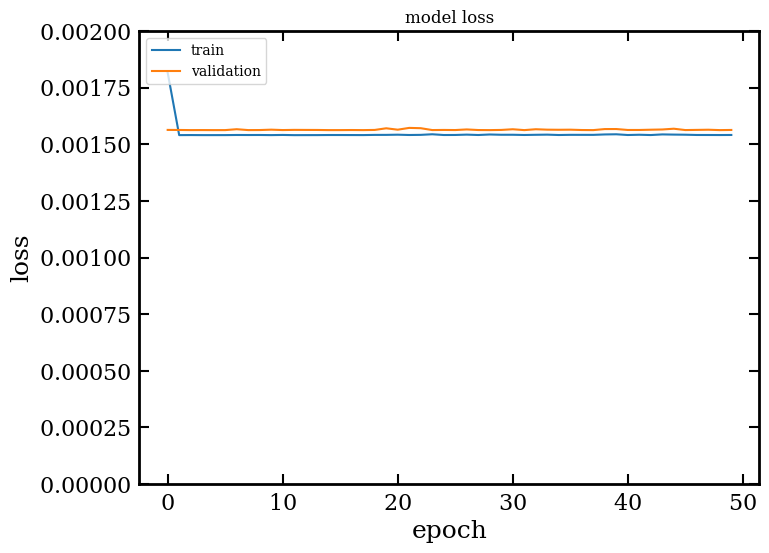

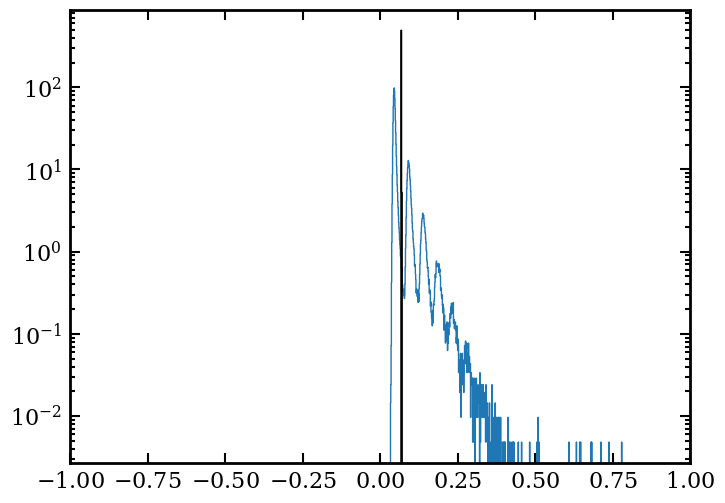

In [76]:
#Let's simply train on R


X_train, X_test, y_train, y_test = train_test_split(dist_non_zero, labels_non_zero,
                                               test_size=0.2, random_state=0)

sc_y = preprocessing.MaxAbsScaler()
sc_x = StandardScaler()

X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

sc_x.fit(X_train)
X_train = sc_x.transform(X_train)
sc_x.fit(X_test)
X_test = sc_x.transform(X_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

sc_y.fit(y_train)
y_train = sc_y.transform(y_train)
sc_y.fit(y_test)
y_test = sc_y.transform(y_test)

model = Sequential()
model.add(Dense(2, input_dim=1,kernel_initializer='normal', activation=activ))
model.add(Dense(10000, activation=activ))
model.add(Dense(1,activation='linear'))

# Model is derived and compiled using mean square error as loss
# function, accuracy as metric and gradient descent optimizer.
model.compile(loss='mse', optimizer='adam', metrics=["mse",'mae'])

epochs = 50

history = model.fit(X_train,y_train,batch_size=10000,epochs=epochs,verbose=1
                    ,validation_split=0.2)

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0.0,0.002])
plt.show()

model_output = model.predict(X_test)

hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(y_test,bins=1000,histtype='step',color='C0',density=True)
plt.hist(model_output,bins=hist_bins,histtype='step',color='k',density=True)
plt.yscale('log')
plt.xlim([-1.0,1.0])
plt.show()

In [ ]:
#Now I'm going to try a Gaussian process
#
#with sklearn it takes up too much memory, but lets see what happens with TF

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

def build_gp(amplitude, length_scale, observations_nose_variance):
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
    
    retrun tfd.GaussianProcess(
        kernel=kernel,
        index_points=observation_index_points_,
        observation_noise_variance=observation_noise_variance)
    
gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': build_gp,
})

<ipython-input-10-a78db000baa7>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_test = h5py.File('test_data.hdf5')


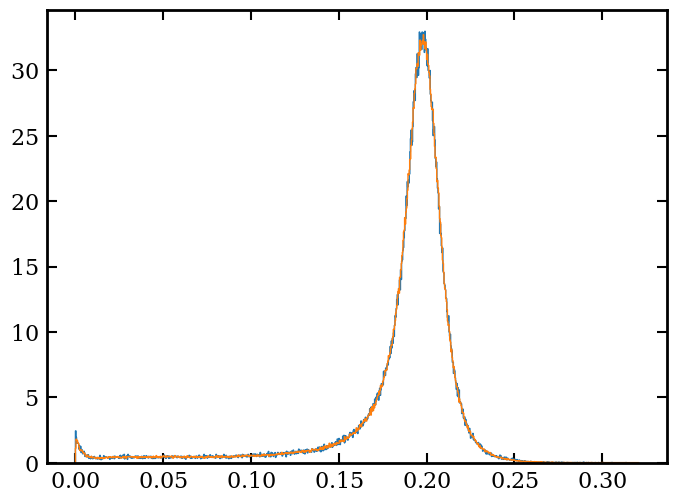

In [10]:
f_test = h5py.File('test_data.hdf5')
f_test.keys()

y_test = f_test['y_test']
y_train = f_test['y_train']

plt.hist(y_test,bins=1000,histtype='step',density=True)
plt.hist(y_train,bins=1000,histtype='step',density=True)
plt.show()

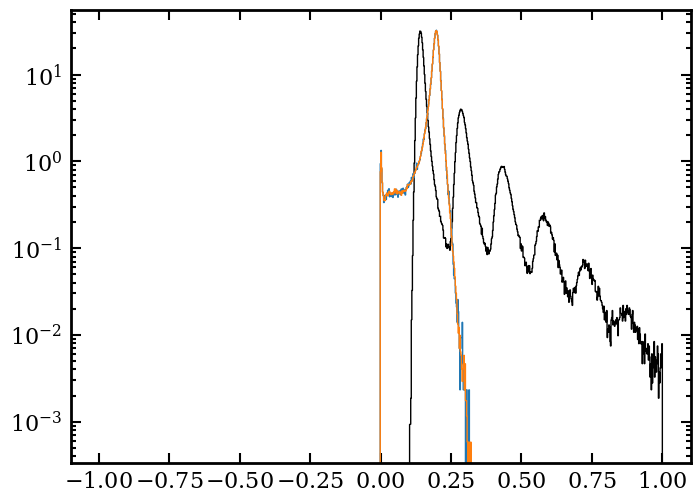

In [14]:
hist_bins = np.linspace(-1.0,1.0,1000)
plt.hist(labels_non_zero,bins=hist_bins,histtype='step',density=True,color='k')
plt.hist(y_test,bins=hist_bins,histtype='step',density=True)
plt.hist(y_train,bins=hist_bins,histtype='step',density=True)
plt.yscale('log')
plt.show()

In [15]:
print(labels_non_zero.shape)

(1073770,)
